In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from pathlib import Path
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

In [4]:
class ProteinDataset(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.y, self.xres, self.af = torch.load(self.path / f'{id}.pt')
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.y[i]

In [5]:
lengths = [4096, 512, 256, 256]
path = Path('ml_samples/'+'-'.join([str(l) for l in lengths]))
samples = [f.stem for f in path.iterdir()]

from lib.retrieve_data import retrieve_target_list
ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
targetlist = retrieve_target_list()
skip = [targetlist.loc[id, 'pdb_code'].upper() for id in ids]
samples = sorted(list(set(samples) - set(skip)))

train, test = train_test_split(samples, test_size=0.35, random_state=42)
torch.save((train, test), 'ml_data/split.pt')
# train, test = to ch.load('ml_data/split.pt')
train_dataset = ConcatDataset([ProteinDataset(s, path) for s in train])
test_dataset = ConcatDataset([ProteinDataset(s, path) for s in test])
trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset)

(47572, 25179, 72751)

In [6]:
X,xres,af,y = train_dataset[2]

h = 0.5
kdews = [1,1,1,1]
weights = torch.tensor(np.concatenate([np.array([w]*l) for w,l in zip(kdews, lengths)]))
kde = gaussian_kde(X, weights=weights, bw_method=h)
kde([0,0])
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())

[-1.81818182  1.81818182] 9.193181265651215e-05


In [138]:
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
h = 0.5
results = []
for i in range(0,10,2):
    wi = np.power(2,i)
    for j in range(0,10,2):
        wj = np.power(2,j)
        for k in range(0,10,2):
            wk = np.power(2,k)
            for l in tqdm(range(0,10,2)):
                wl = np.power(2,l)
                ws = [wi,wj,wk,wl]
                weights = np.concatenate([np.array([w]*l) for w,l in zip(ws, lengths)])
                for i in np.random.choice(len(train_dataset), 16):
                # for i,(x, xres, af, y) in enumerate(train_dataset):
                    print(i)
                    x, xres, af, y = train_dataset[i]
                    x = x.numpy()
                    y = y.numpy()
                    kde = gaussian_kde(x, weights=weights, bw_method=h)
                    probs = kde(grid).reshape(phi_grid.shape)
                    kdepeak = grid[:,probs.argmax()]
                    dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
                    results.append([wi,wj,wk,wl,dist])
                    # if i == 15:
                        # break
                    with open ('results_.csv', 'a') as f:
                        f.write(f'{wi},{wj},{wk},{wl},{dist}\n')
df = pd.DataFrame(results, columns=['w4', 'w5', 'w6', 'w7', 'da'])
df.to_csv('results.csv', index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

2779
8420
38917
46840
35717
11849
12686
14188
38678
42107
42589
14709
6645
23233
8771
22131


 20%|██        | 1/5 [00:04<00:16,  4.15s/it]

10766
33265
14415
19072
36815
11450
5933
14180
32897
19768
32569
24887
42691
15547
21780
15101


 40%|████      | 2/5 [00:08<00:12,  4.15s/it]

20335
8748
44546
37953
29701
6648
7301
39126
10055
37685
7739
16868
21451


 40%|████      | 2/5 [00:11<00:17,  5.86s/it]


KeyboardInterrupt: 

In [129]:
df.groupby(['w4', 'w5', 'w6', 'w7']).sum().sort_values('da')

da
w4 w5 w6 w7              
1  1  1  64    637.646407
         256   641.919875
         16    970.517634
      4  4    1137.937146
         1    1146.229084
      1  4    1149.431535
         1    1324.981261

In [ ]:
import statsmodels.api as sm

X = df[['w4', 'w5', 'w6', 'w7']]
X = sm.add_constant(X)
y = df['da']
model = sm.OLS(y, X).fit()

In [72]:
from scipy.optimize import minimize
X,xres,af,y = train_dataset[2]
X = np.array(X)
y = np.array(y)

def kde(params):
    # weights = np.concatenate([np.array([w]*l) for w,l in zip(params, lengths)])
    weights = np.concatenate([np.repeat(params[0], lengths[0]), np.repeat(params[1], lengths[1]), np.repeat(params[2], lengths[2]), np.repeat(params[3], lengths[3])])
    kde = gaussian_kde(X, weights=weights, bw_method=h)
    phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
    grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
    probs = kde(grid).reshape(phi_grid.shape)
    kdepeak = grid[:,probs.argmax()]
    # diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
    # dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
    print(kdepeak - y)
    return (kdepeak - y).sum()

res = minimize(kde, [0.5]*4, bounds=[(0, None)]*4)

[  80.14232844 -119.67427271]
[  80.14232844 -119.67427271]
[  80.14232844 -119.67427271]
[  80.14232844 -119.67427271]
[  80.14232844 -119.67427271]


In [73]:
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -39.531944274902344
        x: [ 5.000e-01  5.000e-01  5.000e-01  5.000e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 5
     njev: 1
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

# KDE from scratch

In [84]:
from scipy.stats import multivariate_normal as norm
x = torch.tensor([-121,147]) - X.T[0]
pdf = norm.pdf(x, mean=[0,0], cov=[[0.5,0],[0,0.5]])
pdf

0.1950058709573979

In [82]:
h = 2
h_mat = torch.eye(2) * h
print(h_mat)
h_mat = torch.inverse(h_mat) # 2x2 matrix
print(h_mat)
x = torch.tensor([1.,.23]) # 2x1 "column vector"
print(x)
this = x @ h_mat # x.T @ h_mat: 1x2 @ 2x2 = 1x2 "row vector"
print('this',this)
print('x=',this @ x) # 1x2 @ 2x1 = 1x1 "scalar"

# shortcut
print('x=',x.pow(2).sum() / h)

tensor([[2., 0.],
        [0., 2.]])
tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]])
tensor([1.0000, 0.2300])
this tensor([0.5000, 0.1150])
x= tensor(0.5264)
x= tensor(0.5264)


In [160]:
torch.det(torch.eye(5)*5)

tensor(3125.)

In [172]:
from scipy.linalg import cholesky
X,xres,af,y = train_dataset[4]
cov = np.cov(X, rowvar=True, aweights=weights)
cho_cov = cholesky(cov, lower=True) * h # lower triangular
cho_cov_det = 1 / np.linalg.det(cho_cov) # product of diagonal

[[ 27.33670903   0.        ]
 [-19.93507038  32.87465315]]


0.0011127371568900029

tensor(733.0771, dtype=torch.float64)
[-0.50139276 -0.50139276] tensor(7.1661e-05, dtype=torch.float64)


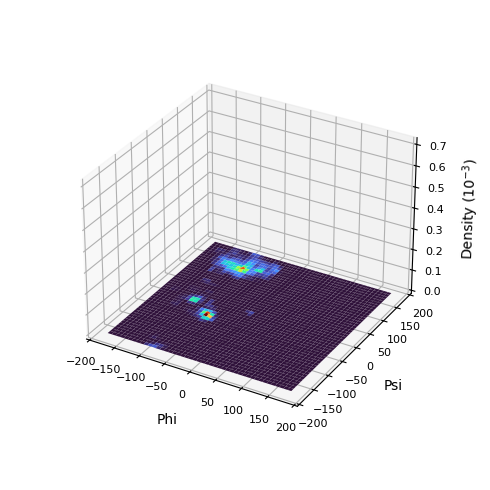

In [208]:
X,xres,af,y = train_dataset[2]

from scipy.stats import gaussian_kde
kdews = [1,1,1,1]
weights = torch.tensor(np.concatenate([np.array([w]*l) for w,l in zip(kdews, lengths)]))
# weights = weights / weights.sum()
# X = X.numpy()
# X
# plt.plot(weights)

# Kernel Density Estimation
h = 0.5
cov = np.cov(X, rowvar=True, aweights=weights)
cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal
print(h_det)
# h_det = torch.det(torch.eye(2) * h)
def K(x):
    # 2 dimensional standard normal distribution
    # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
    return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
def kde(xi):
    xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
    if xi.ndim == 1:
        xi = xi.unsqueeze(1)
    # xi = xi.unsqueeze(2)
    # global X
    # X = X.unsqueeze(0)
    xi = xi.T.unsqueeze(-1)
    # print(xi.shape, X.shape)
    # print((X-xi).shape)
    # print(X[:,:,:5])
    # print(xi)
    # print((X-xi)[:,:,:5])
    likelihood = K(X.unsqueeze(0) - xi) #* weights
    # print((likelihood.sum(dim=1) / weights.sum()).shape)
    likelihood = likelihood.sum(dim=1) / weights.sum()
    return likelihood

# Find most likely dihedral angles
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
# grid = grid[:,500:505]
# grid = grid[:,:10]
probs = kde(grid).reshape(phi_grid.shape)
# probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
print(kdepeak, probs.max())

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.tight_layout()

[-1.81818182  1.81818182] 9.193181265651215e-05


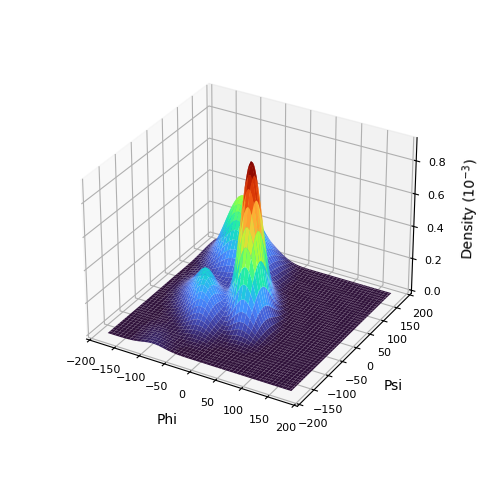

In [207]:
kde = gaussian_kde(X, weights=weights, bw_method=h)
kde([0,0])
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.tight_layout()